# Tutorial 4 - Pioneer
This tutorial models a potential design for a WEC used to provide power to instruments in the [Pioneer Central Surface Mooring System](https://oceanobservatories.org/site/cp01cnsm/) within the National Science Foundation Ocean Observatories Initiative [Coastal Pioneer Array](https://oceanobservatories.org/array/coastal-pioneer-array/).
This system has instrumentation to measure various meteorological, surface, near-surface, and seabed phenomena on the Continental Shelf-Slope and transmit back to shore.

Unlike previous tutorials, this tutorial does not include an outer optimization loop.
Instead, the focus here is on effectively modeling an optimization problem for the control of a unique WEC archetype with a pitch resonator PTO with several co-dependent components.
This is completely setup in Part 1, and includes:

* Expanding the control state vector
* Custom PTO physics
* Modeling non-hydrodynamic degrees of freedom

This tutorial is divided into three parts.
The first sets up the problem including the points above.
The second and third show results using a regular and irregular wave, respectively.

1. [Model setup](#1.-Model-setup)
2. [Regular wave results](#2.-Regular-wave-results)
3. [Irregular wave](#3.-Irregular-wave)


<p><img src=https://oceanobservatories.org/wp-content/uploads/2015/09/Central-Surface-Mooring-Array-01-1.png alt="Diagram of the Pioneer device" width="200"></p>

In [334]:
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Model setup

### 1.1 Waves
We start with setting up the different waves we want to model, as this will inform what to select for our frequency range, which we need throughout the rest of the problem setup. 
We will consider two waves: a regular wave and an irregular wave, both with typical characteristics of the deployment site.
The regular wave is roughly at 0.35 Hz, the known pitch resonance frequency of the buoy.
The irregular wave has a peak period of 5 seconds, matching that of the deployment site.

Please refer to Tutorial 3 for information about selecting the number of realizations.
For the purpose of the tutorial, the number of realizations has been set to 2 to reduce runtime.

The procedure for determining an appropriate frequency array for irregular wave conditions is detailed at the end of this tutorial.

In [335]:
fend = 1.875
nfreq = 150
f1 = fend / nfreq

f1_reg = .325/2
nfreq_reg = 12

In [336]:
# regular
amplitude = 0.15
wavefreq = 0.325
waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)

# irregular
Hs = 1.5
Tp = 5 

nrealizations = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations=nrealizations)

We plot the wave elevation spectra to check if the chosen frequency array covers the main excitation frequency, converges to zero for larger frequencies and can capture multiple harmonics which are required for nonlinear dynamics, since the states are multiplied with each other.

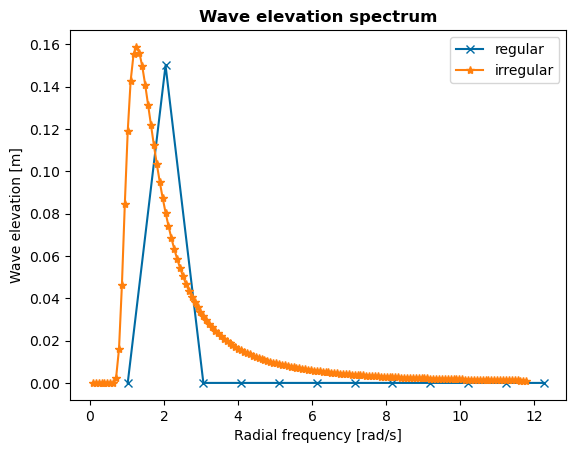

In [337]:
#TODO: highlight the harmonics if wave freq and Tp with other markers+colors
fig, ax = plt.subplots()
np.abs(waves_regular).plot(marker = 'x', label="regular")
np.abs(waves_irregular.sel(realization=0)).plot(marker = '*', label="irregular")
ax.set_title('Wave elevation spectrum', fontweight='bold')
plt.legend()

### 1.2 Basic properties

#### Geometry
To get the required hydrodynamic coefficients of the Pioneer design, we only need to be concerned with creating a mesh of the buoy geometry.
The buoy has the same general shape as the WaveBot used in Tutorial 1, so we will use the build-in `geom.WaveBot` object and change the dimensions to simplify the mesh creation process.

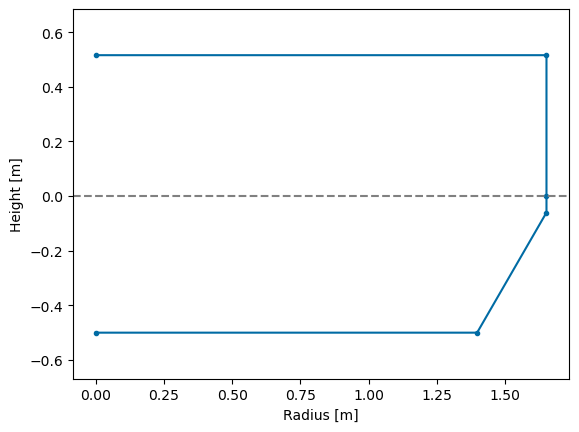

In [338]:
in2m = 0.0254 # inch -> meter conversion factor
draft = 0.5 # meters
freeboard = 40. * in2m - draft
hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                             r2=110./2 * in2m, 
                             h1=22.679 * in2m,
                             h2=17.321 * in2m,
                             scale_factor=1,
                             freeboard=freeboard)
mesh = hull_geom.mesh(mesh_size_factor=0.5)
_ = hull_geom.plot_cross_section()

#### Design properties
The Pioneer team has developed initial specifications for a full-sized WEC design that fits within the buoy dimensions and operating at resonance.
There are several components that we need to capture in the PTO model:

* **Buoy**: As mentioned, this has the same basic geometric parameters as the WaveBot used in Tutorial 1.
Since we're only modeling the pitch degree of freedom, we only need the pitch moment of inertia and not the mass of the buoy.
* **Flywheel**: The flywheel is contained and dimensioned to fit on top of the buoy.
It rotates in pitch independently of the buoy, but is linked to the buoy through two parallel connections: the torsional spring and the generator.
Since the flywheel is protected from wave loading by the buoy, it is **not** subject to hydrostatics or hydrodynamics.
* **Spring**: The magnetic torsional spring provides positive stiffness to the flywheel.
It has a linear displacement up to 45 degrees, at which point it "wraps around" and the stiffness begins decreasing.
For simplicity, we will model the spring as strictly linear.
The spring is connected to a gearbox which makes the position of the spring (and therefore, the generator shaft) different from the relative position of the flywheel and buoy. 

A rendering of the Pioneer WEC model is shown here with the buoy pitch in red and the flywheel pitch in green:
<p><img src=https://live.staticflickr.com/65535/53025745404_2e75c89894_k.jpg alt="Diagram of the Pioneer device" width="500"></p>

In [339]:
buoy_props = {
    'CG': 0.298, # m
    'MOI': 7484., # kg-m^2
    'Resonance frequency': 0.35, # Hz
}

# flywheel properties at example resonance
flywheel_properties = {
    'coulomb_friction': 4.5, # N*m
    'viscous_friction': 0.02, # N*ms/rad
    'motor_gear_ratio': 0.118,
    'MOI': 22.32, # kg*m^2
}

spring_properties = {
    'stiffness': 835.36, # N*m/rad
    'gear_ratio': 0.334,
    'Max torque': 750, # N-m
    'Max displacement': np.deg2rad(45.0), # rad
}

# PTO properties
pto_properties = {
    'gear_ratio': 1.0,
    'torque_constant': 0.164,
    'winding_resistance': 0.0718,
    'winding_inductance': 0.0,
    'drivetrain_inertia': 0.0,
    'drivetrain_friction': 0.0,
    'drivetrain_stiffness': 0.0,
}

#### Pitch resonator
This system uses a unique PTO system, where the generator velocity is dependent on the relative pitching rotation of the buoy and the flywheel.
The system can be modeled as a coupled spring-mass-damper system, with the generator represented as $B_{PTO}$.
The spring-mass-damper system and equivalent circuit model are shown below.
Note that all of these values are rotational and are drawn here linearly for simplicity. 

<p><img src=https://live.staticflickr.com/65535/53025028262_1a4ba2d5ce_z.jpg alt="Pioneer model as a spring-mass-damper system" width="500"> <img src=https://live.staticflickr.com/65535/53025140497_29c5b9d601_z.jpg alt="Pioneer model as a spring-mass-damper system" width="180"></p>

This corresponds to the following dynamics equations:

(1)

$$ [J_{buoy} + J(\omega))] \ddot{\theta}_{buoy} = T_{hydro} - K_{hydro}\theta_{buoy} - B(\omega)\dot{\theta}_{buoy} - K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 - (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

(2)

$$ J_{flywheel} \ddot{\theta}_{flywheel} = K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 + (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

We will explore how to capture these dynamics in WecOptTool in the following sections.

#### Hydrodynamics and hydrostatics
As mentioned above, the `FloatingBody` object in Capytaine only needs to model the buoy, since no other components are being excited by the waves.

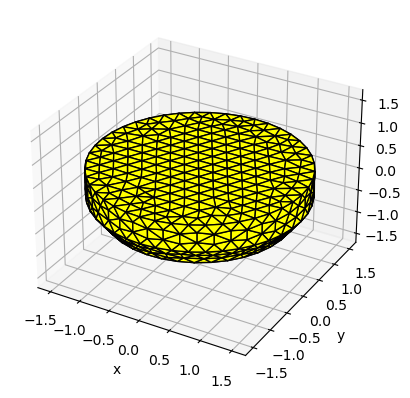

In [340]:
pnr_fb = cpy.FloatingBody.from_meshio(mesh, name="Pioneer")
pnr_fb.add_rotation_dof(name='Pitch')
pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
pnr_fb.rotation_center = pnr_fb.center_of_mass
ndof = pnr_fb.nb_dofs
pnr_fb.show_matplotlib()

pnr_fb.inertia_matrix = xr.DataArray(data=np.asarray(([[buoy_props['MOI']]])),
                            dims=['influenced_dof', 'radiating_dof'],
                            coords={'influenced_dof': list(pnr_fb.dofs),
                                    'radiating_dof': list(pnr_fb.dofs)},
                            name="inertia_matrix")

In [341]:
rho = 1025. # kg/m^3
freq = wot.frequency(f1_reg, nfreq_reg, False) # False -> no zero frequency
bem_data = wot.run_bem(pnr_fb, freq)
omega = bem_data.omega.values

pnr_fb.keep_immersed_part()
k_buoy = pnr_fb.compute_hydrostatic_stiffness(rho=rho).values.squeeze()
k_spring = spring_properties['Max torque'] / spring_properties['Max displacement']
print(f'Hydrostatic stiffness from Capytaine: {k_buoy} N-m/rad')
print('Hydrostatic stiffness from experiment: 37204 N-m/rad')

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.21e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel 

Hydrostatic stiffness from Capytaine: 38313.990221854474 N-m/rad
Hydrostatic stiffness from experiment: 37204 N-m/rad


As with previous tutorials, we will plot the hydrodynamic coefficients to confirm that we are properly capturing the full excitation range of the buoy.

<xarray.DataArray 'inertia_matrix' (influenced_dof: 1, radiating_dof: 1)>
array([[7484.]])
Coordinates:
    g               float64 9.81
    rho             float64 1.025e+03
    body_name       <U16 'Pioneer_immersed'
    water_depth     float64 inf
  * radiating_dof   (radiating_dof) object 'Pitch'
  * influenced_dof  (influenced_dof) object 'Pitch'


Text(0.5, 1.0, 'Radiation Damping Coefficients')

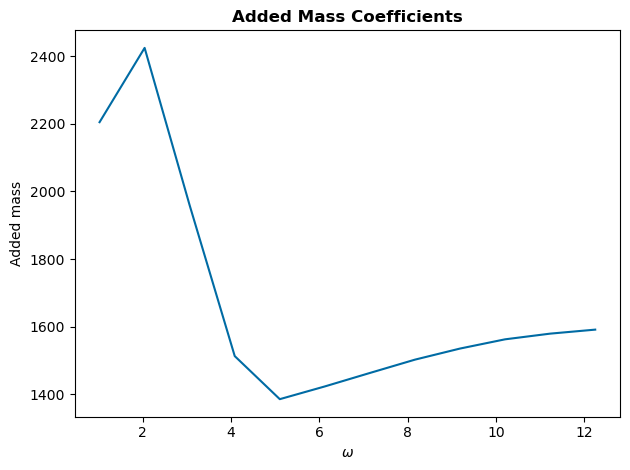

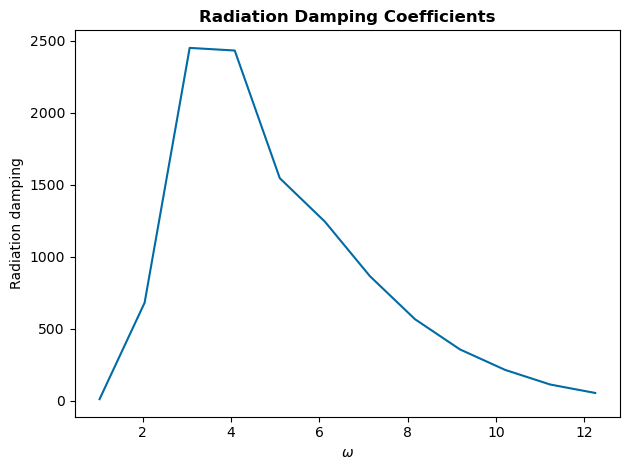

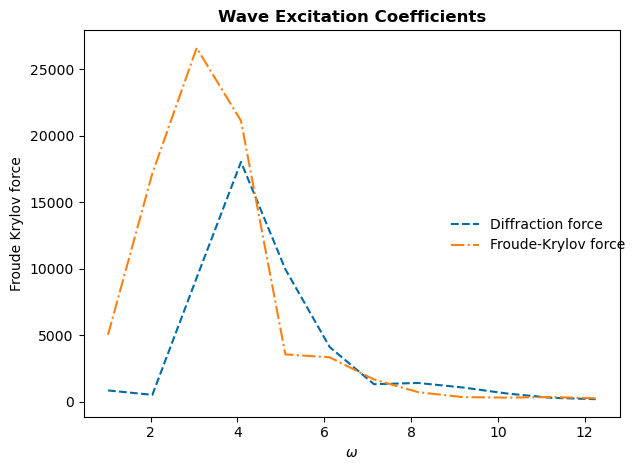

In [342]:
print(bem_data['inertia_matrix'])
# Plots
fig_am, ax_am = plt.subplots(tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(tight_layout=True, sharex=True)

# Excitation
np.abs(bem_data.diffraction_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashed', label='Diffraction force')
np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashdot', label='Froude-Krylov force')
ex_handles, ex_labels = ax_ex.get_legend_handles_labels()
ax_ex.set_xlabel(f'$\omega$', fontsize=10)
ax_ex.set_title('Wave Excitation Coefficients', fontweight='bold')
fig_ex.legend(ex_handles, ex_labels, loc='center right', frameon=False)

# Added mass
bem_data.added_mass.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_am)
ax_am.set_xlabel(f'$\omega$', fontsize=10)
ax_am.set_title('Added Mass Coefficients', fontweight='bold')

# Radiation damping
bem_data.radiation_damping.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_rd)
ax_rd.set_xlabel(f'$\omega$', fontsize=10)
ax_rd.set_title('Radiation Damping Coefficients', fontweight='bold')

### 1.3 PTO
The generator shaft velocity is the difference between the buoy velocity and the flywheel velocity.
Because the velocity PTO depends not only on the hydrodynamic states (`x_wec`, buoy pitch) but also on an additional non-hydrodynamic state (flywheel pitch), we cannot use the `PTO` module we have used in previous tutorials.
We will make two adjustments to our previous modeling approach model to accurately model the PTO:

1. Adjust the `x_opt` vector to include the flywheel motion
2. Manually define the PTO dynamics and energy equations in place on the `PTO` module

#### Capturing flywheel motions
In previous tutorials, all the relevant WEC dynamics have been captured in the `x_wec` vector.
However, `x_wec` assumes all the degrees of freedom are excited by waves, which is not the case for the flywheel in the Pioneer model.
Instead, we will include the flywheel dynamics in the `x_opt` vector.

The `x_opt` vector has previously only been used to model the PTO force.
However, there is no limit to what `x_opt` can include; it can theoretically include anything that is needed to model the PTO control.
Here, we will append the Fourier coefficients of the flywheel's position to `x_opt`.
The first part of `x_opt` will continue to be used for the PTO force (i.e. Fourier coefficients of the force time-series for an unstructured controller). 

Note in the code further down that `x_opt` will be spliced as either `x_opt[:nstate_pto]` to exclude the flywheel position states, or `x_opt[nstate_pto:]` to exclude the PTO force states.
Remember, `x_opt` can be defined arbitrarily, and specific meanings to the states are given elsewhere in the model.

In [343]:
nstate_pto = 2 * nfreq_reg # PTO forces
nstate_fw = 2 * nfreq_reg  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

#### Manually defining PTO equations
Instead of calling the `PTO` module, we will manually define the dynamics and energy equations needed for WecOptTool to calculate electrical power, our quantity of interest for this optimization problem.
These equations are also needed for the additional forces and constraints defined later on.

##### Relative motion
Here we define functions for the relative motion of the buoy and flywheel, derived from `x_wec` and `x_opt` respectively.

In [344]:
def x_rel(wec, x_wec, x_opt):
    pos_wec = wec.vec_to_dofmat(x_wec)
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    return pos_wec - pos_fw

def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, pos_rel)

def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    vel_rel = np.dot(wec.derivative_mat, pos_rel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_rel)

In [345]:
torque_constant = 3.512
winding_resistance = 0.304

z_11 = np.array([[np.zeros(omega.shape)]])
off_diag = np.sqrt(3.0/2.0) * torque_constant
z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])

In [346]:
z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

##### Unstructured controller
This is nearly identical to the `wot.pto.controller_unstructured` function, except `x_opt` is spliced to only include the first part, since we are also including the flywheel positions in the second part of `x_opt`.

In [347]:
def f_motor(wec, x_wec, x_opt, waves, nsubsteps=1):
    motor = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, motor)

def force_from_generator(wec, x_wec, x_opt, waves=None, nsubsteps=1):
    f_fd = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    torque = np.dot(time_matrix, f_fd)
    return torque

def force_from_friction(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
        rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps) * flywheel_properties['motor_gear_ratio']
        fric =  -1*(
            np.tanh(rel_vel)*flywheel_properties['coulomb_friction'] +
            rel_vel*flywheel_properties['viscous_friction']
        ) * flywheel_properties['motor_gear_ratio']
        return fric

def force_from_lin_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
        pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) * spring_properties['gear_ratio']
        return spring_properties['gear_ratio'] * -spring_properties['stiffness'] * pos

##### PTO Impedance
The PTO impedance is defined using the same 2-port impedance model as in previous tutorials.
The drivetrain inertia, friction, and stiffness are not included here since they are accounted for in the modeling of the additional non-hydrodynamic degree of freedom via additional forces and constraints below.

In [348]:
def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = force_from_generator(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = f_motor(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf


In [349]:
torque_peak_max = 120.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

max_generator_torque = 25.8 # N*m
nsubsteps_constraints = 5

def constraint_max_generator_torque(wec, x_wec, x_opt, waves, nsubsteps=nsubsteps_constraints):
    torque = force_from_generator(wec, x_wec, x_opt, waves, nsubsteps)
    return max_generator_torque - np.abs(torque.flatten())

def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps) * flywheel_properties['motor_gear_ratio']
    return -1 * (
        np.tanh(rel_vel) * flywheel_properties['coulomb_friction']
      + rel_vel * flywheel_properties['viscous_friction']
    ) * flywheel_properties['motor_gear_ratio']

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) * spring_properties['gear_ratio']
    spring_force = -spring_properties['stiffness']  * pos * spring_properties['gear_ratio']
    return spring_force

def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_properties['MOI'] * acc_fw

def flywheel_inertia(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_properties['MOI'] * acc_fw

def const_flywheel_resid(wec, x_wec, x_opt, waves):
    return (fw_inertia(wec, x_wec, x_opt, waves)
          + f_spring(wec, x_wec, x_opt, waves)
          + f_friction(wec, x_wec, x_opt, waves)
          + force_from_generator(wec, x_wec, x_opt, waves) * flywheel_properties['motor_gear_ratio']
          ).flatten()

def flywheel_residual_lin_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    resid = (
    flywheel_inertia(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_lin_spring(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_friction(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_generator(wec, x_wec, x_opt, waves, nsubsteps) * flywheel_properties['motor_gear_ratio']
    )
    return resid.flatten()

f_add = {
    'Motor': force_from_generator,
    'Friction': f_friction,
    'Spring': f_spring,
}

f_add_lin_spring = {
    'Generator': force_from_generator,
    'Friction': f_friction,
    'Spring': force_from_lin_spring,}

constraints = [
    {'type': 'ineq', 'fun': constraint_max_generator_torque},
    {'type': 'eq', 'fun': const_flywheel_resid},
]

constraints_lin_spring = [
    {'type': 'eq', 'fun': flywheel_residual_lin_spring}, # flywheel EoM
    {'type': 'ineq', 'fun': constraint_max_generator_torque},
]

When using the `PTO` module, the 2x2 impedance matrix is passed to the `wot.pto.PTO` object and converted into a transfer matrix to calculate the power at each frequency.
While we are not using the `PTO` module, we will repeat this process almost verbatim here.
See the `_make_abcd` and `_make_mimo_transfer_mat` functions in the `PTO` module if you are interested in more technical details.

z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

##### Power and Energy
Finally, we will wrap the relative motions, force, and impedance functions together to calculate average electrical power.
This is again very close to what is found in the `PTO` module, except `rel_velocity` replaces `wot.pto.PTO.velocity` and `f_motor` replaces `wot.pto.PTO.force`.

def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = f_motor(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf

### 1.4 Constraints
The Pioneer model only contains one constraint based on the motor being used:

 * **Peak torque** - The motor should avoid torques greater than 120 N-m.
 This is the same basic constraint as `const_f_pto` from Tutorial 1, except we use our `f_motor` definition instead of `wot.pto.PTO.force_on_wec`.

### 1.5 Additional forces
Here we add in the forces acting on the bodies other than those generated from wave loading.

 * **Motor damping** - The resisting torque resulting from the damping on the PTO.
 This is very similar to the `wot.pto.PTO.force_on_wec` additional force given in previous tutorials. 
 This is already being accounted for by the `f_motor` function above.
 * **Flywheel friction** - The dissipative torque from the generator and components.
 This is defined as a nonlinear force using both Coulomb friction (dependent on the PTO direction) and the viscous friction (dependent on the PTO speed).
 * **Magnetic spring** - The restoring torque caused by the torsional spring between the buoy and flywheel.
 Note the gear ratio is included in this equation, as the gearbox is connected in series with the spring.
 The position of the spring is the relative position of the flywheel and buoy scaled by the reciprocal of gear ratio squared. 

def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return -1 * (
        np.tanh(rel_vel) * flywheel_props['Coulomb friction']
      + rel_vel * flywheel_props['Viscous friction']
    )

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
    spring_force = -k_spring  * pos
    return spring_force

### 1.6 Flywheel residual equation
To make sure the flywheel dynamics are properly modeled in the pseudo-spectral method, we will introduce an equality constraint consisting of Newton's 2nd law of motion on the flywheel in residual form:

$$ r(x) = I \alpha - \tau = 0 $$

This is the same structure as the residual for the WEC dynamics described in the [WecOptTool theory documentation](https://sandialabs.github.io/WecOptTool/theory.html).
Also compare this equation to the 2nd dynamics equation listed [above](#pitch-resonator).

This is required because the equations of motion described by `x_wec` only capture the buoy pitch degree of freedom.
This equation provides a second equality constraint to capture the flywheel pitch degree of freedom, resulting in two coupled dynamic equations.

def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_props['MOI'] * acc_fw

def const_flywheel_resid(wec, x_wec, x_opt, waves):
    return (fw_inertia(wec, x_wec, x_opt, waves)
          + f_spring(wec, x_wec, x_opt, waves)
          + f_friction(wec, x_wec, x_opt, waves)
          + f_motor(wec, x_wec, x_opt, waves)
          ).flatten()

f_add = {
    'Motor': f_motor,
    'Friction': f_friction,
    'Spring': f_spring,   
}

constraints = [
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'eq', 'fun': const_flywheel_resid},
]

We now create the additional forces and constaints that will be passed to the `WEC` object.
Note that `f_add` only pertains to the buoy since that is the only degree of freedom included in the BEM data; our flywheel residual equation handles these forces for the flywheel in the opposite direction.

### 1.7 WEC object
We now have all the information required to create our `WEC` object.

In [350]:

wec = wot.WEC.from_bem(bem_data,
                       f_add=f_add,
                       constraints=constraints,
                       uniform_shift=False,
                       dof_names=bem_data.influenced_dof.values,)

## 2. Regular wave results

### 2.1 Solve
As in previous tutorials, we will optimize for electrical power absorption.

In [351]:
obj_fun = average_electrical_power
results = wec.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8.337996422651443
            Iterations: 7
            Function evaluations: 8
            Gradient evaluations: 7
Optimal average power: -833.80 W


### 2.2 Post-process and plot
Again, since we are not using the `PTO` module, post-processing using `wot.pto.PTO.post_process` is not an option here, so we have to manually post-process the outputs related to the PTO and flywheel.
This is pretty intuitive using the functions we created earlier.
The outputs related to the buoy can still be derived directly from `wot.wec.post_process`.

In [352]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(wec,results, waves_regular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq_reg)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)


Some observations about the optimized Pioneer model:

 * The flywheel and buoy match frequency, but are out of phase due to the forcing from the spring and motor applied to both bodies.
 * The gearing in series with the torsional spring (which reduces the effective spring stiffness) significantly amplifies the rotation of the flywheel despite the buoy only pitching modestly.
 The gear ratio of 3 was selected by the Pioneer team to keep the system in resonance considering the spring stiffness, moment of inertia of the flywheel, and the resonance frequency of the buoy.
 Try increasing the gear ratio or flywheel moment of inertia—this will actually reduce the power generated since it will bring the effective stiffness of the flywheel out of resonance, causing less motion relative to the buoy.
 * The mechanical and electrical power outputs are similar, since our impedance model has only a small amount of resistance and no inductance.
 * The buoy's pitch amplitude is larger than expected for this device and is likely due to underestimation of the radiation damping by the BEM. 

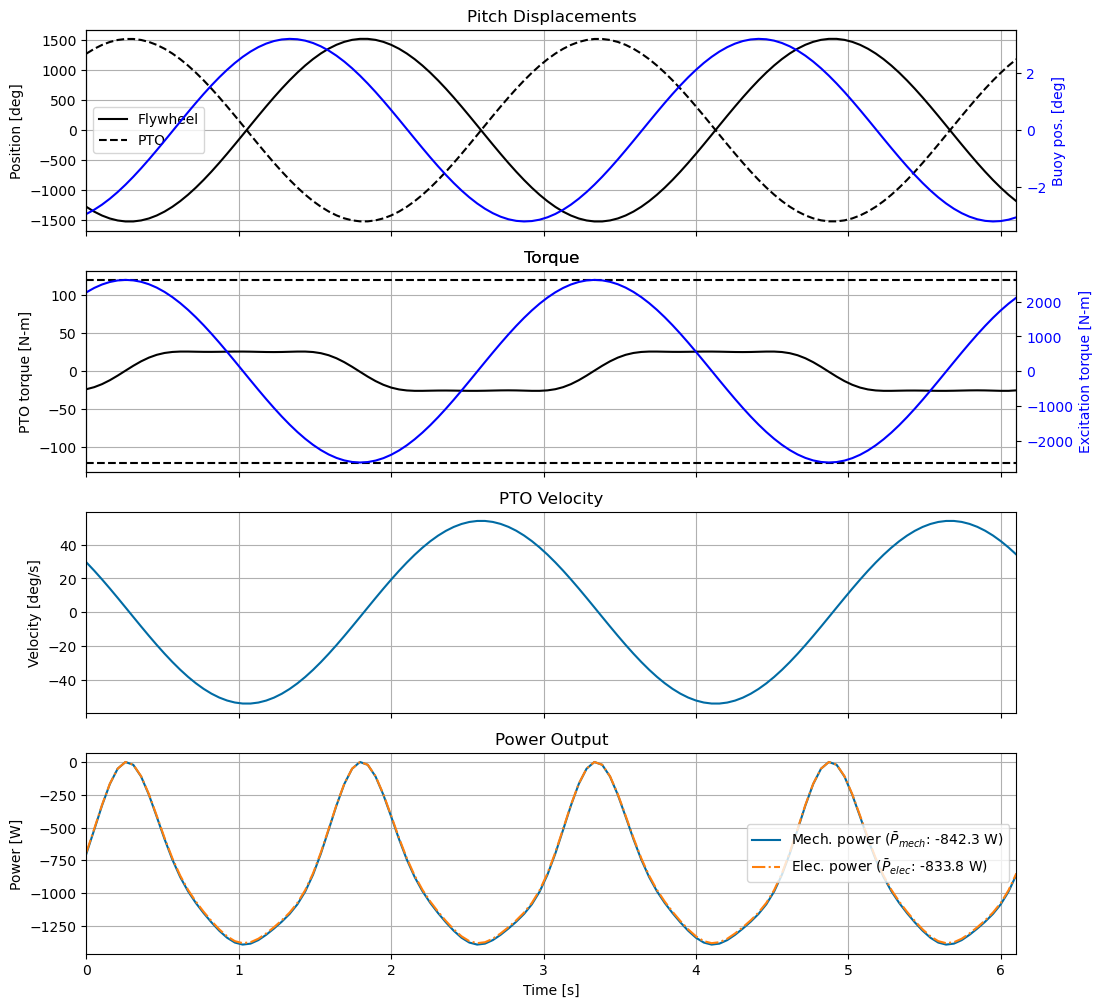

In [353]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom[0].time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom[0].pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom[0]['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

### 2.3 Sankey Diagram
We use a Sankey diagram to visualize the average power flow from waves to electricity.
The left end shows the theoretically possible optimal excitation.
In order to reach this upper bound of excitation, the WEC pitch velocity would need to be in phase with the pitch excitation force (or, in this case, the radiated power is equal the amount of absorbed mechanical power).
In practice, this will usually imply putting electrical power into the system (something we want to avoid!!!).

With co-design, we are instead tapping the unused potential while limiting PTO losses and radiated power.

In [354]:
hydro_data = wot.add_linear_friction(bem_data, friction=None)
hydro_data = wot.check_radiation_damping(hydro_data, uniform_shift=False)

Zi = wot.hydrodynamic_impedance(hydro_data)
Rad_res = np.real(Zi.squeeze())

Fex = wec_fdom.force.sel(type=['Froude_Krylov', 'diffraction']).sum('type')
Vel = wec_fdom.vel

P_max_absorbable = (np.abs(Fex)**2/(8*Rad_res) ).squeeze().sum('omega').item() # after Falnes Eq. 6.10
P_opt_excitation = 2*P_max_absorbable # after Falnes Eq. 6.10
P_radiated = ((1/2)*(Rad_res * np.abs(Vel)**2 ).squeeze().sum('omega').item()) # after Falnes Eq. 6.4
P_excited= (1/4)*(Fex*np.conjugate(Vel) + np.conjugate(Fex)*Vel ).squeeze().sum('omega').item() # after Falnes Eq. 6.3
P_absorbed = P_excited - P_radiated # after Falnes Eq. 6.2 absorbed by WEC-PTO (difference between actual excitation power and actual radiated power needs to be absorbed by PTO)

def fw_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    vel_fw = np.dot(wec.derivative_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_fw)

def fw_friction_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_friction(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = fw_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

fw_fric_power = fw_friction_power(wec, x_wec, x_opt, waves_regular, nsubsteps)
avg_fw_fric_power = np.mean(fw_fric_power)

assert(np.isclose(P_absorbed, -1*(avg_mech_power -avg_fw_fric_power), rtol=0.01)) # assert that solver solution matches

AttributeError: 'list' object has no attribute 'force'

In [ ]:
from matplotlib.sankey import Sankey

P_PTO_loss = avg_mech_power - avg_elec_power
P_unused = P_opt_excitation - P_excited # Difference between the theoretical optimum excitation, if the WEC velocity would be in resonance with the excitation force

Power_flows = [P_opt_excitation, P_PTO_loss, -1*avg_fw_fric_power, -1*P_radiated, -1*P_unused, avg_elec_power, ]

fig = plt.figure(figsize = [6,4])
ax = fig.add_subplot(1, 1, 1,)
sankey = Sankey(ax=ax,
                scale=0.5/P_max_absorbable,
                offset= 0,
                format = '%.2f W',shoulder = 0.02)

sankey.add(flows=Power_flows,
           labels = ['Optimal Excitation \n $ 2 \\frac{\left | F_e \\right |^2}{8Re(Z_i)} = 2*P_{mech}^{max}$ ',
                      'PTO-Loss \n $ P_{mech} - P_{elec}$',
                      'Flywheel friction',
                      'Radiated \n $ \\frac{1}{2} Re(Z_i) \left | U \\right |^2  $ ',
                      'Unused Potential \n(neither absorbed nor radiated)',
                      'Electrical'],
           orientations=[0, -1, -1,-1, -1, 0], # arrow directions
           pathlengths = [0.4,0.2,0.6,0.6,0.7,0.5,],
           trunklength = 1.5,
           edgecolor = '#2b8cbe',
           facecolor = '#2b8cbe' )

diagrams = sankey.finish()
for diagram in diagrams:
    for text in diagram.texts:
        text.set_fontsize(10);
plt.axis("off")
plt.show()

We also calculate the power dissipated due to flywheel friction and make sure that the absorbed power (calculated as the difference between excited and radiated power) matches the sum of mechanical power captured by the PTO and the power dissipated due to flywheel friction.
We use a relative tolerance of 1%.

ValueError: The scaled sum of the connected flows is 85.1648107161103, which is not within the tolerance (0.09179746650450316)

c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\IPython\core\events.py:82: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


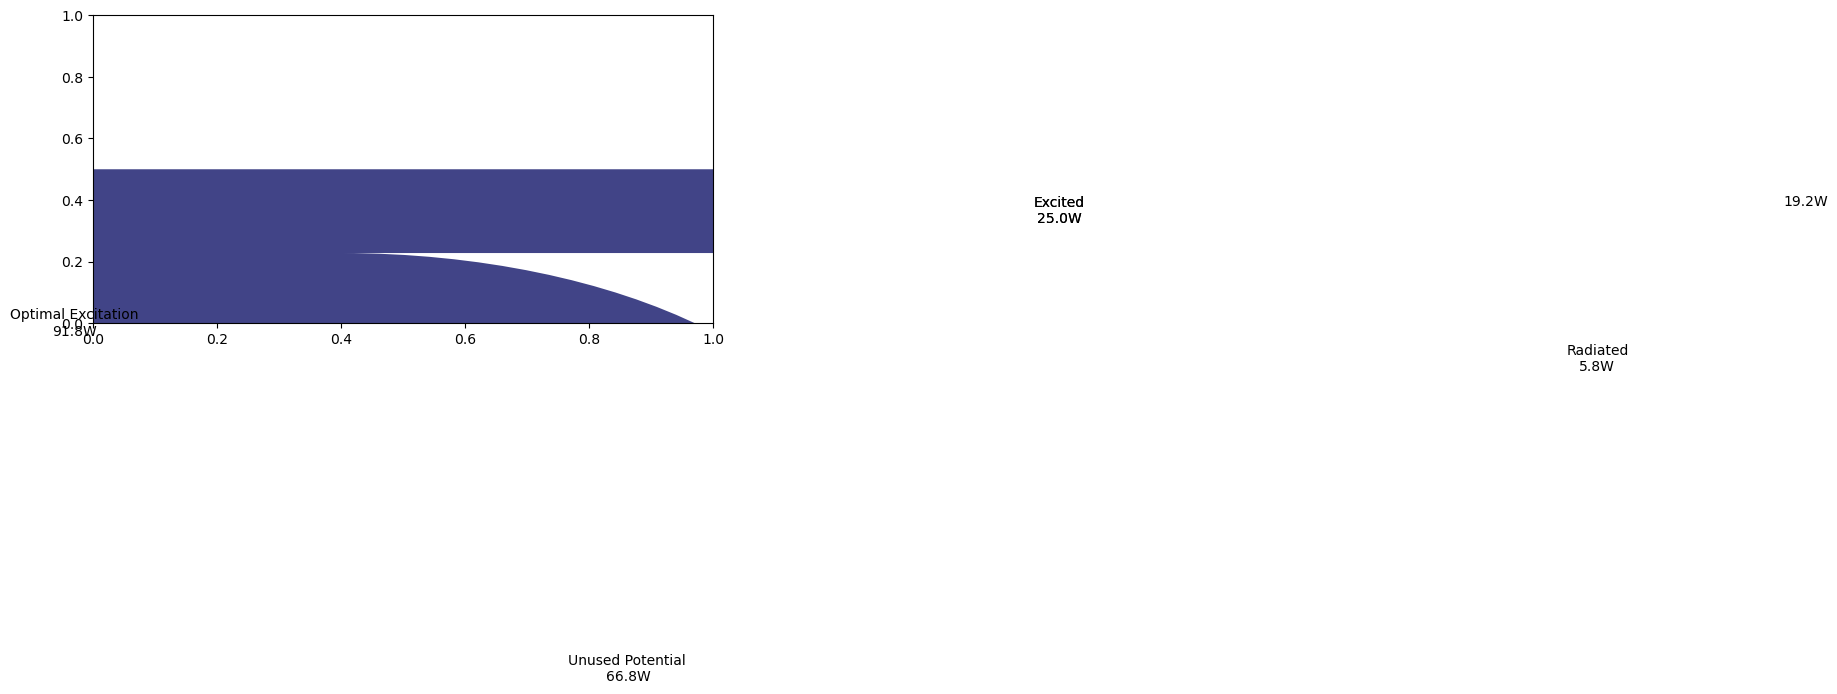

In [ ]:
wot.utilities.plot_power_flow(power_flows)

## 3. Irregular wave

### 3.1 Solve
We will now run the same analysis for irregular waves. 

Interestingly, due to the narrow banded resonance of the flywheel, the controller attempts to make the excitation force monochromatic with the resonant frequency.
To achieve this, it uses significant reactive power (power by the PTO into the system).
This is still worth it though, resulting in a larger average electrical power output.

As noted previously, the optimization problem is solved for each wave realization.
The optimal average power shown is the total average across the different realizations.

In [ ]:
obj_fun = average_electrical_power
results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
power_results = [result.fun for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')

c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0000306544538002
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15


c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
c:\Users\jtgrasb\Anaconda3\envs\wecopttool2_0_0\lib\site-packages\autograd\numpy\numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0873460858017983
            Iterations: 15
            Function evaluations: 18
            Gradient evaluations: 15
Optimal average power: -304.37 W


### 3.2 Post-process and plot

In [ ]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(wec,results, waves_irregular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

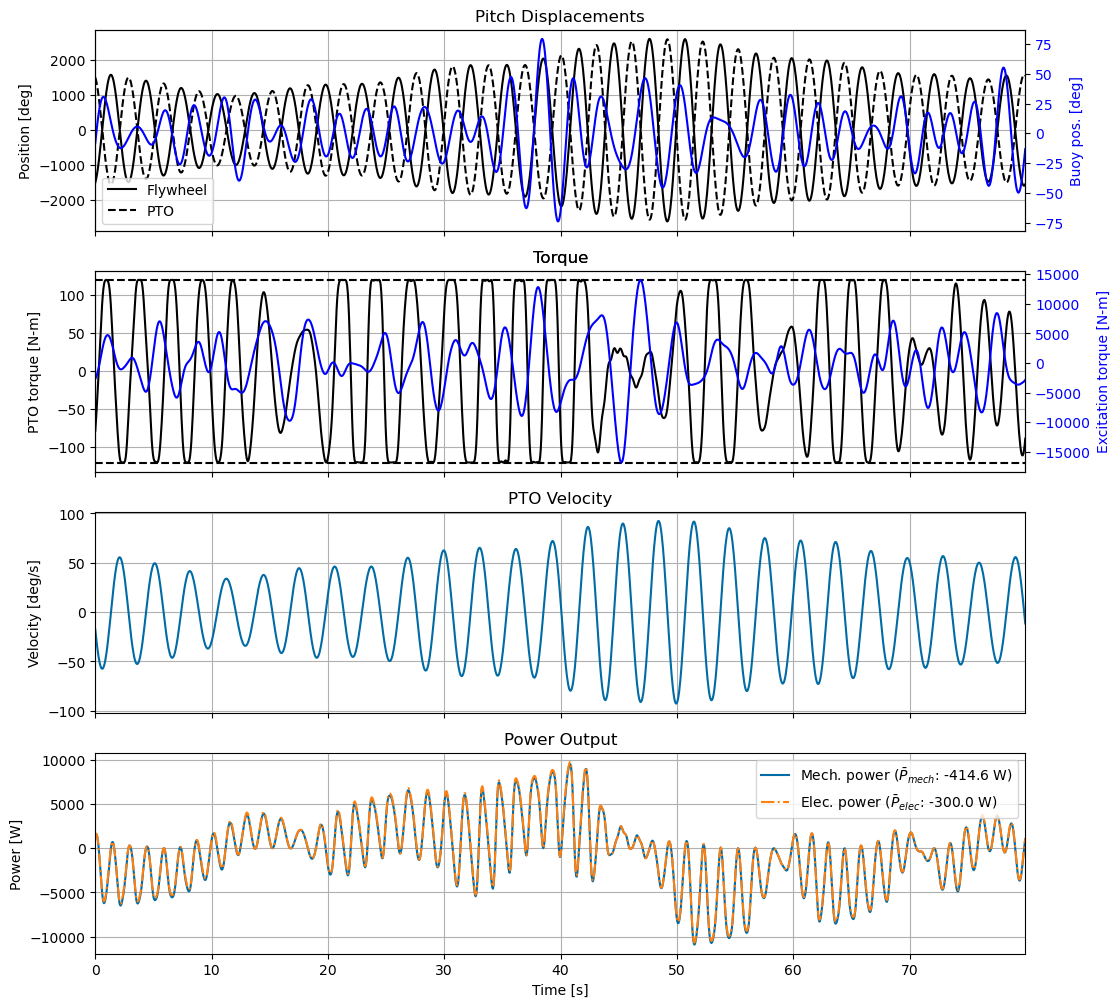

In [ ]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom[0].time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom[0].pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom[0]['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

### 3.3 Notes on selection of frequency array and realizations
In order to determine a suitable frequency range, it is best to complete an optimization with a large frequency range and examine the frequency domain results to see how large a range of frequencies is necessary to capture the relavent dynamics.
Often, capturing nonlinear dynamics (such as due to constraints) requires a larger frequency range.
In the case of the Pioneer WEC, it is clear that (likely due to the PTO torque constraint) the nonlinearities cause excitation at the odd harmonics of the excited frequency (which is slightly larger than the wave frequency itself for the Pioneer system).
Specifically, the PTO force has significant peaks around the excited frequency and at the 3rd harmonic (with a small peak at the 5th harmonic as well) which leads to peaks in the frequency spectrum of electrical power at the 2nd, 4th, and 6th harmonics.
The frequency values are normalized in the plots below to more clearly show the harmonics.
In order to capture most of these nonlinearities, we chose a frequency range from 0 to 1.875 for this tutorial. 

Text(0.5, 0, 'Frequency (normalized according to excited frequency)')

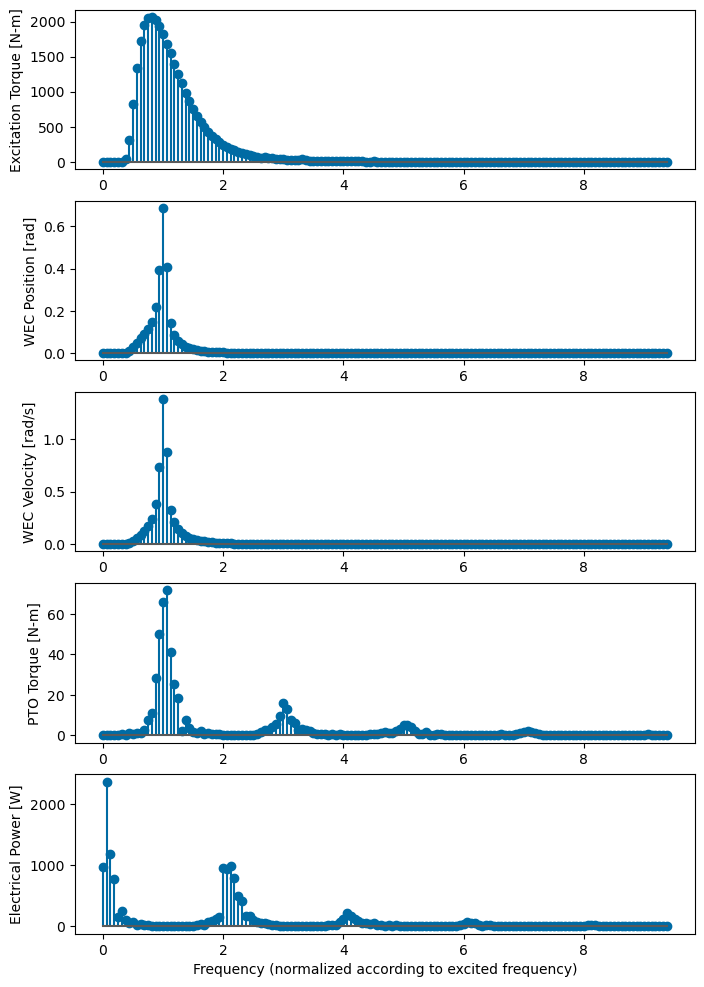

In [ ]:
filename = 'data/tutorial_4_freq_range.nc'
results = wot.read_netcdf(filename)

excited_freq = abs(results['pos']).argmax()
normalized_freq = results['freq']/results['freq'][excited_freq]

fig, ax = plt.subplots(5,1,figsize=(8, 12))
ax[0].stem(normalized_freq,abs(results['exc_force']))
ax[0].set_ylabel('Excitation Torque [N-m]')
ax[1].stem(normalized_freq,abs(results['pos']))
ax[1].set_ylabel('WEC Position [rad]')
ax[2].stem(normalized_freq,abs(results['vel']))
ax[2].set_ylabel('WEC Velocity [rad/s]')
ax[3].stem(normalized_freq,abs(results['pto_force']))
ax[3].set_ylabel('PTO Torque [N-m]')
ax[4].stem(normalized_freq,abs(results['power']))
ax[4].set_ylabel('Electrical Power [W]')
ax[4].set_xlabel('Frequency (normalized according to excited frequency)')

After determining a frequency range of interest, it is important to make sure enough frequencies are included in the array to generate accurate results.
The Pioneer WEC has a very narrow banded response, which means it requires a large number of frequencies to model the response accurately.
For any WecOptTool analysis in irregular wave conditions, it is best to complete a convergence study on the number of frequencies in the wave conditions of interest.
The convergence study shown below varies the number of frequencies and includes enough realizations of each array to reach a 20 minute total simulation time (discussed further below).
As shown below, an array of 150 frequencies is sufficient to model the system to within about 2% of the actual resultant mean power.
Because the computation time increases with increasing number of frequencies, it is desirable to select the number of frequencies to minimize the computation time while meeting the intended accuracy.

Text(0, 0.5, 'Computation time per realization [min]')

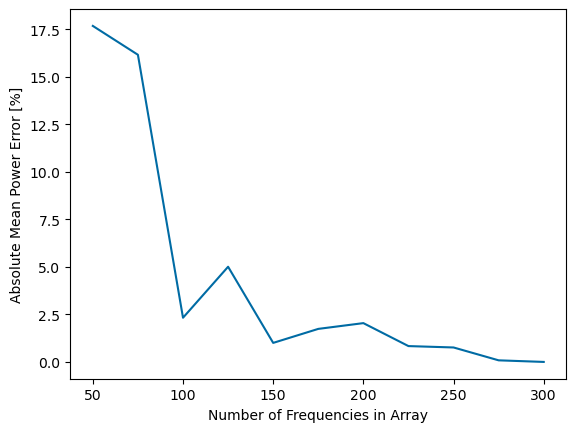

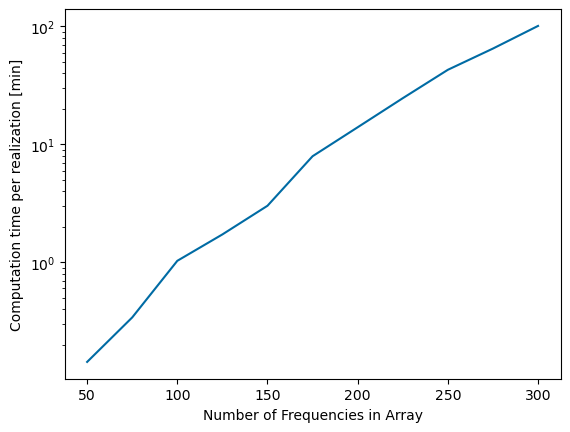

In [ ]:
filename = 'data/tutorial_4_nfreqs.nc'
results = wot.read_netcdf(filename)

power_percent_error = abs((results['power'] - results['power'][-1])/results['power'][-1])*100
time_per_realization = results['comp_time']/results['nrealizations']

plt.figure()
plt.plot(results['nfreqs'],power_percent_error)
plt.xlabel('Number of Frequencies in Array')
plt.ylabel('Absolute Mean Power Error [%]')

plt.figure()
plt.semilogy(results['nfreqs'],time_per_realization/60)
plt.xlabel('Number of Frequencies in Array')
plt.ylabel('Computation time per realization [min]')

Next, the number of phase realizations should be considered.
Generally, it is recommended that enough realizations be used for the total simulation time to equal 20 minutes. 

$$ t_{total} = \frac{n_{realizations}}{f1} $$

Although it usually leads to consistent results, this recommendation is somewhat arbitrary.
To better understand the effect of the number of realizations on the overall result, it can be useful to complete a convergence study.
The actual number of realizations needed depends on the problem itself (dynamics, constraints, etc.) and the desired precision of the result.
As shown below, in the case of the Pioneer WEC, after about 15 realizations (20 minutes total simulation time) the result is within about 0.5% of the converged result which is deemed sufficient for this study.

Text(0.5, 0, 'Total simulation time [min]')

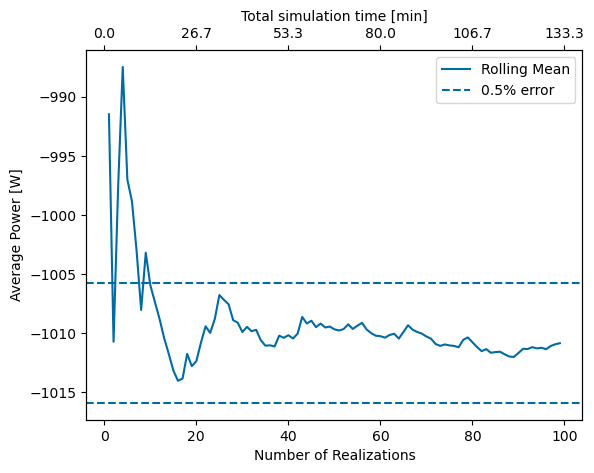

In [ ]:
filename = 'data/tutorial_4_nrealizations.nc'
results = wot.read_netcdf(filename)

rolling_mean = []
for ind in range(len(results['power'])):
    rolling_mean.append(np.mean(results['power'][0:ind]))
    
error_bar = rolling_mean[-1]*.005

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(results['realization'],rolling_mean,label='Rolling Mean')
ax1.set_xlabel('Number of Realizations')
ax1.set_ylabel('Average Power [W]')
ax1.axhline(rolling_mean[-1]+error_bar,ls='--',label='0.5% error')
ax1.axhline(rolling_mean[-1]-error_bar,ls='--')
ax1.legend()

tper_realization = (results['nfreq']/results['fend']).values # time per realization

def tick_function(X):
    V = tper_realization*X/60
    return ["%.1f" % z for z in V]

ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax1.get_xticks()))
ax2.set_xlabel('Total simulation time [min]')